In [ ]:
# default_exp modeling.text2text.summarization

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# modeling.text2text.summarization

> This module contains custom models, custom splitters, etc... summarization tasks.

In [ ]:
#export
import ast, inspect, torch
from transformers import *
from fastai.text.all import *
from rouge_score import rouge_scorer, scoring

from blurr.utils import *
from blurr.data.core import *
from blurr.data.text2text.core import *
from blurr.data.text2text.summarization import *
from blurr.modeling.core import *
from blurr.modeling.text2text.core import *

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1
Using fastai 2.1.8
Using transformers 4.0.1


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Summarization

The objective of summarization is to generate a concise and accurate representation of a much larger body of text.  For example, we may want to summarize an article in a single sentence.

In [ ]:
path = Path('./')
cnndm_df = pd.read_csv(path/'cnndm_sample.csv'); len(cnndm_df)

1000

In [ ]:
cnndm_df.head(2)

,article,highlights,ds_type
0,"(CNN) -- Globalization washes like a flood over the world's cultures and economies. Floods can be destructive; however, they can also bring blessings, as the annual floods of the Nile did for ancient Egypt. The world's great universities can be crucial instruments in shaping, in a positive way, humankind's reaction to globalization and the development of humankind itself. Traditionally, universities have been defined and limited by location, creating an academic community and drawing students and scholars to that place. Eventually, some universities began to encourage students to study el...","John Sexton: Traditionally, universities have been defined and limited by location .\nGlobal campuses form a network of thought, innovation, he writes .\nFaculty can teach, Sexton says, students can team up in many cities at once .\nSexton: Research, scholarship can be shared and cultural ties made in ""century of knowledge""",train
1,"(CNN) -- Armenian President Robert Kocharian declared a state of emergency Saturday night after a day of clashes between police and protesters, a spokeswoman for the Armenian Foreign Ministry said. Opposition supporters wave an Armenian flag during a protest rally in Yerevan, Armenia, on Saturday. The protesters claim last month's presidential election was rigged. The state of emergency will ""hopefully bring some order"" to the capital, Yerevan, said Salpi Ghazarian, assistant to the Armenian foreign minister, who spoke to CNN early Sunday. The state of emergency could last until March 20, ...","NEW: Protest moves after crackdown at Freedom Square .\nOrder sought after protests over last month's election turn violent .\nDemonstrators say the election was fraudulent .\nState of emergency could last until March 20, official says .",train


In [ ]:
#hide

# pretrained_model_name = "t5-small"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
#                                                                                model_cls=T5ForConditionalGeneration)

# pretrained_model_name = "google/pegasus-cnn_dailymail"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
#                                                                                model_cls=PegasusForConditionalGeneration)

# pretrained_model_name = "facebook/bart-large-cnn"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
#                                                                                model_cls=BartForConditionalGeneration)


In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
before_batch_tfm = HF_SummarizationBeforeBatchTransform(hf_arch, hf_tokenizer, max_length=[256, 130])
blocks = (HF_Text2TextBlock(before_batch_tfms=before_batch_tfm, input_return_type=HF_SummarizationInput), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(cnndm_df, bs=2)

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 68]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"(CNN) -- Home to up to 10 percent of all known species, Mexico is recognized as one of the most biodiverse regions on the planet. The twin threats of climate change and human encroachment on natural environments are, however, threatening the existence of the country's rich wildlife. And there is a great deal to lose. In the United Nations Environment Program (UNEP) World Conservation Monitoring Centre's list of megadiverse countries Mexico ranks 11th. The list represents a group of 17 countries that harbor the majority of the Earth's species and are therefore considered extremely biodiverse. From its coral reefs in the Caribbean Sea to its tropical jungles in Chiapas and the Yucatan peninsula and its deserts and prairies in the north, Mexico boasts an incredibly rich variety of flora and fauna. Some 574 out of 717 reptile species found in Mexico -- the most in any country -- can only be encountered within its borders. It is home to 502 types of mammals, 290 species of birds, 1,150 varieties of birds and 26,000 classifications of plants. Pronatura, a non-profit organization that works to promote conservation and sustainable development in Mexico, has selected six species which it says symbolize the problems faced by the","Mexico hosts to up to 10 percent of all known species on Earth.\nIt is home to 502 types of mammals, 290 bird species and 26,000 types of plants.\nHuman development and climate change is placing a big strain on its biodiversity.\nThe Golden Eagle is under threat in spite of being the country's national symbol."
1,"London (CNN) -- In 1948, a hospital outside London witnessed the birth of the Paralympic movement, as a Jewish doctor who had fled Nazi Germany sought to change the lives of patients with spinal injuries -- and inspire new hope in them through sport. The first ""Stoke Mandeville Games"" were organized in 1948 to coincide with the London Olympics, the second to be held in Britain. Named for the hospital in Buckinghamshire where Prof. Ludwig Guttmann's pioneering spinal injuries unit was based, the competitors in those initial Games -- 14 men and two women -- took part in a wheelchair archery contest. Many were military veterans injured on the battlefields of World War II. Just a year later, six teams competed at Stoke Mandeville -- with wheelchair netball, a forerunner of wheelchair basketball, being introduced -- as sport became a central part of a rehabilitation process that had been revolutionized by Guttmann. In 1956, a ""statement of intent"" was unveiled for the Games, which were by this time international, according to to the Mandeville Legacy website run by the local authority. It read: ""The aim of the Stoke Mandeville Games is to unite paralyzed men and women from all parts of the world in an international sports","Paralympic movement was born in Stoke Mandeville, outside London, in 1948.\n2012 Games will be the biggest yet, with 4,200 competitors from 165 countries.\nIn an echo of the first, post-World War II Games, injured veterans are among the athletes.\nThey include a U.S. naval officer blinded in Afghanistan and a Briton who lost an arm in Iraq."


### Metrics

In this section, we'll add helpful metrics for summarization tasks

In [ ]:
#export
def calculate_rouge(predicted_txts, reference_txts, rouge_keys=["rouge1", "rouge2", "rougeL"], use_stemmer=True):
    scorer = rouge_scorer.RougeScorer(rouge_keys, use_stemmer=use_stemmer)
    aggregator = scoring.BootstrapAggregator()

    for ref_text, pred_txt in zip(reference_txts, predicted_txts):
        scores = scorer.score(ref_text, pred_txt)
        aggregator.add_scores(scores)

    result = aggregator.aggregate()
    return result

### Training

Here we create a summarization specific subclass of `HF_BaseModelCallback` in order to include custom, summarization specific, metrics, and also handle the pre-calculated loss during training

In [ ]:
#export
class HF_SummarizationModelCallback(HF_BaseModelCallback):  
    def __init__(self, rouge_metrics=["rouge1", "rouge2", "rougeL"], 
                 ignore_token_id=CrossEntropyLossFlat().ignore_index,
                 text_gen_kwargs={}, **kwargs):
        
        super().__init__(**kwargs)
        
        self.run_before = Recorder
        
        store_attr(self=self, names='rouge_metrics, ignore_token_id, text_gen_kwargs, kwargs')
        self.custom_metrics_dict = { k:None for k in rouge_metrics }
        
        self.do_setup = True
        
    def setup(self):
        # one time setup code here.
        if (not self.do_setup): return
        
        # grab the hf_tokenizer from the target's HF_TokenizerTransform (used for rouge metrics)
        hf_textblock_tfm = self.learn.dls.before_batch[0]
        self.hf_tokenizer = hf_textblock_tfm.hf_tokenizer
        self.tok_kwargs = hf_textblock_tfm.tok_kwargs
        
        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys ])
        self.learn.metrics = self.learn.metrics + custom_metrics
        
        self.do_setup = False
        
    def before_fit(self): self.setup()
        
        
    # --- batch begin/after phases ---
    def after_batch(self):
        if (self.training or self.learn.y is None): return
        
        # grab predicted and reference ids for any metrics that need them
        input_ids, attention_mask = self.xb[0]['input_ids'], self.xb[0]['attention_mask']
        gen_ids = self.learn.model.hf_model.generate(input_ids=input_ids, 
                                                     attention_mask=attention_mask, 
                                                     use_cache=True,
                                                     **self.text_gen_kwargs)
        
        
        self.generated_ids += gen_ids.tolist()
        self.refernce_ids += [ seq[seq != self.ignore_token_id].tolist()  for seq in self.yb[0] ]

    # --- validation begin/after phases ---
    def before_validate(self): self.generated_ids, self.refernce_ids = [], []
        
    def after_validate(self):
        # are there rouge metrics to calculate?
        if (self.rouge_metrics is not None and len(self.rouge_metrics) > 0):
            gen_texts = self.hf_tokenizer.batch_decode(self.generated_ids, 
                                                       skip_special_tokens=True, 
                                                       clean_up_tokenization_spaces=True)

            ref_texts = self.hf_tokenizer.batch_decode(self.refernce_ids, 
                                                       skip_special_tokens=True, 
                                                       clean_up_tokenization_spaces=True)

            rouge_results = calculate_rouge(gen_texts, ref_texts, rouge_keys=self.rouge_metrics)
            
            for rouge_key, scores in rouge_results.items(): 
                self.custom_metrics_dict[rouge_key] = scores.mid.fmeasure
                

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key): return self.custom_metrics_dict[metric_key]

We add a custom param splitter to give us a bit more depth in applying discriminative learning rates for summarization.

In [ ]:
#export
def summarization_splitter(m, arch):
    """Custom param splitter for summarization models"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m
    
    if arch in ['bart', 'pegasus']:     
        embeds = nn.Sequential(
            model.model.shared, 
            model.model.encoder.embed_positions, 
            model.model.encoder.embed_tokens,
            model.model.decoder.embed_positions, 
            model.model.decoder.embed_tokens
        )
        
        groups = L(embeds, model.model.encoder, model.model.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)
    
    if arch in['t5']:
        embeds = nn.Sequential(
            model.shared, 
            model.encoder.embed_tokens,
            model.decoder.embed_tokens
        )
        
        groups = L(embeds, model.encoder, model.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)
    
    raise ValueError('Invalid architecture')

In [ ]:
show_doc(summarization_splitter)

<h4 id="summarization_splitter" class="doc_header"><code>summarization_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>summarization_splitter</code>(**`m`**, **`arch`**)

Custom param splitter for summarization models

In [ ]:
text_gen_kwargs = { **hf_config.task_specific_params['summarization'], **{'max_length': 130, 'min_length': 30} }
text_gen_kwargs

{'early_stopping': True,
 'length_penalty': 2.0,
 'max_length': 130,
 'min_length': 30,
 'no_repeat_ngram_size': 3,
 'num_beams': 4}

In [ ]:
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs:
    if k not in generate_func_args: del text_gen_kwargs[k]
        
text_gen_kwargs

{'early_stopping': True,
 'length_penalty': 2.0,
 'max_length': 130,
 'min_length': 30,
 'no_repeat_ngram_size': 3,
 'num_beams': 4}

In [ ]:
model = HF_BaseModelWrapper(hf_model)
model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(), #HF_PreCalculatedLoss()
                cbs=[model_cb],
                splitter=partial(summarization_splitter, arch=hf_arch)) #.to_native_fp16() #.to_fp16()

learn.create_opt() 
learn.freeze()

In [ ]:
# learn.blurr_summary()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds),preds['loss'].shape, preds['logits'].shape

(3, torch.Size([]), torch.Size([2, 68, 50264]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 4, torch.Size([2, 256]), 2, torch.Size([2, 68]))

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=4.365158383734524e-05)

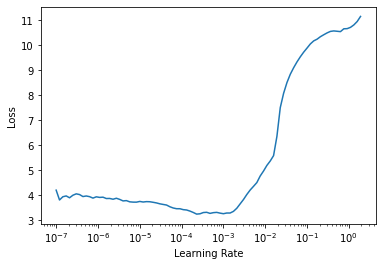

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=4e-5)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,1.924587,1.751489,0.399466,0.175125,0.268440,03:37


### Showing results

Below we'll add in additional functionality to take advantage of huggingface's `PreTrainedModel.generate` model, which can be used to easily implement beam search, top-k/nucleous sampling, etc... so that we get more human sounding results.

In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""

In [ ]:
res = learn.blurr_predict(test_article)
print(hf_tokenizer.decode(res[0][0][0][:20]))

 10 10                About 10 men with with pistols and machine machine guns raid a casino in Switzerland and made


That doesn't look much like a human-generated summary.  Let's use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [ ]:
b = dls.valid.one_batch()

b_before_batch_tfm = dls.before_batch[0]
b_hf_tokenizer = before_batch_tfm.hf_tokenizer
b_ignore_token_id = before_batch_tfm.ignore_token_id

test_input_ids = b[0]['input_ids'][0].unsqueeze(0).to(learn.model.hf_model.device)
test_trg_ids = b[1][0].unsqueeze(0).to(learn.model.hf_model.device)
test_trg_ids = [ trg[trg != b_ignore_token_id] for trg in test_trg_ids ]

gen_text = learn.model.hf_model.generate(test_input_ids, num_beams=4, max_length=130, min_length=30)

print('=== Target ===')
print(f'{b_hf_tokenizer.decode(test_trg_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)}\n')

print('=== Prediction ===')
print(b_hf_tokenizer.decode(gen_text[0], skip_special_tokens=True, clean_up_tokenization_spaces=True))

=== Target ===
 Sanjay Gupta: Moral hazard causes some to neglect health when they get health insurance.
He says Obamacare alone won't guarantee good health; personal habits must do that.
He says research shows 30 minutes of daily exercise cuts heart attack, stroke risk by a third.
Gupta: It's time to stop playing defense on your health; instead, start optimizing it yourself.

=== Prediction ===
 Bob Greene: My uncle, who has always been a robust and healthy guy, fell off the wagon when he got Medicare.
He says he ate potato chips, exercised only sporadically, and paid hardly any attention to what he was eating.
For him, becoming newly insured had nearly the opposite effect on him of what we doctors hope to achieve.
In many ways, Greene says, he was demonstrating a concept known as the moral hazard.


We'll add a `blurr_summarize` method to `Learner` that uses huggingface's `PreTrainedModel.generate` to create our predictions.  For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
#export
@patch
def blurr_summarize(self:Learner, inp, **kwargs):
    """Uses the built-in `generate` method to generate the text 
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    # grab the text generation kwargs
    text_gen_kwargs = self.cbs.filter(lambda el: isinstance(el, HF_SummarizationModelCallback) )[0].text_gen_kwargs
    text_gen_kwargs = { **text_gen_kwargs, **kwargs}
    
    # grab the huggingface tokenizer from the learner's dls.tfms
    hf_textblock_tfm = self.dls.before_batch[0]
    hf_tokenizer = hf_textblock_tfm.hf_tokenizer
    tok_kwargs = hf_textblock_tfm.tok_kwargs

    if (isinstance(inp, str)):
        input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors='pt', **tok_kwargs)
    else:
        # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
        input_ids = inp.as_subclass(Tensor)
        
    input_ids = input_ids.to(self.model.hf_model.device)
    
    gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
    outputs = [ hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) 
               for txt in gen_texts ]
    
    if hf_textblock_tfm.hf_arch == 'pegasus':
        outputs = [o.replace('<n>', ' ') for o in outputs]
    
    return outputs

In [ ]:
show_doc(Learner.blurr_summarize)

<h4 id="Learner.blurr_summarize" class="doc_header"><code>Learner.blurr_summarize</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_summarize</code>(**`inp`**, **\*\*`kwargs`**)

Uses the built-in `generate` method to generate the text 
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

In [ ]:
outputs = learn.blurr_summarize(test_article, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Police say 10 men with pistols and machine guns raided a casino in Switzerland and made off with several hundred thousand Swiss francs .
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino Basel .
One group tried to break into the casino's vault on the lower level but could not get in .
A woman driving by unknowingly blocked the armed robbers' vehicles and was beaten to death .
There were about 600 people in the casino at the time of the robbery .

=== Prediction 2 ===
 Police say 10 men with pistols and machine guns raided a casino in Switzerland and made off with several hundred thousand Swiss francs .
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino Basel .
One group tried to break into the casino's vault on the lower level but could not get in .
A woman driving by unknowingly blocked the robbers' vehicles and was beaten to death .
There 

Much nicer!!! Now, we can update our @typedispatched `show_results` to use this new method.

In [ ]:
#export
@typedispatch
def show_results(x:HF_SummarizationInput, y, samples, outs, learner, ctxs=None, max_n=6, 
                 input_trunc_at=None, target_trunc_at=None, **kwargs):  
    
    before_batch_tfm = learner.dls.before_batch[0]
    hf_tokenizer = before_batch_tfm.hf_tokenizer
    ignore_token_id = before_batch_tfm.ignore_token_id
    
    gen_text_txts = learner.blurr_summarize(x)
    res = L([(
        hf_tokenizer.decode(s[0], skip_special_tokens=True)[:input_trunc_at], 
        hf_tokenizer.decode(s[1][s[1] != ignore_token_id], skip_special_tokens=True)[:target_trunc_at], 
        gen_txt[:target_trunc_at]
    ) for s, gen_txt in zip(samples, gen_text_txts) ])          
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"I have an uncle who has always been a robust and healthy guy. He drank a glass of skim milk every day, bragged about how many pull-ups he was doing and fit into pants he was wearing 20 years before. He didn't take a single medication and retired early. Given that he had no medical problems and ran his own business, he opted to go several years without health insurance. Eventually, when he turned 65, he picked up Medicare. What happened next was a little strange. He fell off the wagon. He exerci","Sanjay Gupta: Moral hazard causes some to neglect health when they get health insurance.\nHe says Obamacare alone won't guarantee good health; personal habits must do that.\nHe says research shows 30 minutes of daily exercise cuts heart attack, stroke","Bob Greene: My uncle, who has always been a robust and healthy guy, fell off the wagon when he got Medicare .\nHe says he ate potato chips, exercised only sporadically, and paid hardly any attention to what he was eating .\nFor him, becoming newly ins"
1,"Watch your step as you climb these stairs, whether spiraling up mountains, narrow passageways or sky-scraping attractions. All is right with the world when you're gazing down from the rooftop of Milan's Duomo. That is, until you remember the steep marble stairs that got you there—and are your only way down. Stairways can leave just as much of an impact on your memory as the places they lead you. Some are so eye-catching they look like they belong in an M.C. Escher painting, while other stairs a",Moon Temple at Machu Picchu can be reached by 600-foot slippery granite steps.\nThe journey to Yosemite's Half Dome requires a long cable ladder.\nA misstep on any of these staircases can be lethal.,"Stairways can leave just as much of an impact on your memory as the places they lead you .\nIn Peru, travelers need to tackle 600 feet of slippery granite rocks to reach the Moon Temple at Machu Picchu .\nAt Yosemite National Park, you can't take a se"


### Inference

In [ ]:
export_fname = 'summarize_export'

In [ ]:
learn.export(fname=f'{export_fname}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_summarize(test_article)

[" Police say 10 men with pistols and machine guns raided a casino in Switzerland and made off with several hundred thousand Swiss francs .\nThe men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino Basel .\nOne group tried to break into the casino's vault on the lower level but could not get in .\nA woman driving by unknowingly blocked the armed robbers' vehicles and was beaten to death .\nThere were about 600 people in the casino at the time of the robbery ."]

## Tests

The tests below to ensure the core training code above works for **all** pretrained summarization models available in huggingface.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained summarization models you are working with ... and if any of your pretrained summarization models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
BLURR_MODEL_HELPER.get_models(task='ConditionalGeneration')

[transformers.models.bart.modeling_bart.BartForConditionalGeneration,
 transformers.models.blenderbot.modeling_blenderbot.BlenderbotForConditionalGeneration,
 transformers.models.fsmt.modeling_fsmt.FSMTForConditionalGeneration,
 transformers.models.mbart.modeling_mbart.MBartForConditionalGeneration,
 transformers.models.mt5.modeling_mt5.MT5ForConditionalGeneration,
 transformers.models.pegasus.modeling_pegasus.PegasusForConditionalGeneration,
 transformers.models.prophetnet.modeling_prophetnet.ProphetNetForConditionalGeneration,
 transformers.models.t5.modeling_t5.T5ForConditionalGeneration,
 transformers.models.xlm_prophetnet.modeling_xlm_prophetnet.XLMProphetNetForConditionalGeneration]

In [ ]:
pretrained_model_names = [
    ('facebook/bart-large-cnn',BartForConditionalGeneration),
    ('t5-small', T5ForConditionalGeneration),
    ('google/pegasus-cnn_dailymail', PegasusForConditionalGeneration)#, ... don't fit on my 1080TI :(
]

In [ ]:
path = Path('./')
cnndm_df = pd.read_csv(path/'cnndm_sample.csv')

In [ ]:
#slow
#hide_output
bsz = 2
inp_seq_sz = 64; trg_seq_sz = 40

test_results = []
for model_name, model_cls in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(model_name, 
                                                                                   model_cls=model_cls)
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n')
    
    # 1. build your DataBlock
    def add_t5_prefix(inp): return f'summarize: {inp}' if (hf_arch == 't5') else inp
    
    before_batch_tfm = HF_SummarizationBeforeBatchTransform(hf_arch, hf_tokenizer, 
                                                            max_length=[inp_seq_sz, trg_seq_sz])
    
    blocks = (
        HF_Text2TextBlock(before_batch_tfms=before_batch_tfm, input_return_type=HF_SummarizationInput), 
        noop
    )
    
    dblock = DataBlock(blocks=blocks, 
                       get_x=Pipeline([ColReader('article'), add_t5_prefix]), 
                       get_y=ColReader('highlights'), 
                       splitter=RandomSplitter())

    dls = dblock.dataloaders(cnndm_df, bs=bsz)

    # 2. build your Learner
    text_gen_kwargs = {}
    if (hf_arch in ['bart', 't5']):
        text_gen_kwargs = { 
            **hf_config.task_specific_params['summarization'], 
            **{'max_length': 30, 'min_length': 10} 
        }
    
    # not all "summarization" parameters are for the model.generate method ... remove them here
    generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
    for k in text_gen_kwargs.copy():
        if k not in generate_func_args: del text_gen_kwargs[k]
    
    
    model = HF_BaseModelWrapper(hf_model)
    model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

    learn = Learner(dls, 
                    model,
                    opt_func=ranger,
                    loss_func=HF_PreCalculatedLoss(),
                    cbs=[model_cb],
                    splitter=partial(summarization_splitter, arch=hf_arch)).to_fp16()

    learn.create_opt() 
    learn.freeze()
    
    # 3. Run your tests
    b = dls.one_batch()

    try:
        print('*** TESTING DataLoaders ***\n')
        test_eq(len(b), 2)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, inp_seq_sz]))
        test_eq(len(b[1]), bsz)

#         print('*** TESTING One pass through the model ***')
#         preds = learn.model(b[0])
#         test_eq(preds[1].shape[0], bsz)
#         test_eq(preds[1].shape[2], hf_config.vocab_size)

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max=1e-3)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, input_trunc_at=500, target_trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== facebook/bart-large-cnn ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,3.239557,3.185986,0.310577,0.127986,0.243113,02:05


,text,target,prediction
0,"(CNN) -- To Disney or not to Disney? For many travelers, especially those with children, it's not even a question they ask. They already know the answer. ""Yes."" To these visitors, Disney is Mickey Mouse, princesses, magic and fun. It's happy memories of childhood brought back",Disney represents magical stories and fun family to fans.\nSome parents delight in their children's wonder during a first visit to Disney.\nSome critics think the company encourages kids to buy too much,"Disney is Mickey Mouse, princesses, magic and fun for many travelers .\nFor many, it's happy memories of childhood .\n"
1,"Police missed speaking with suspected Los Angeles International Airport shooter Paul Ciancia by ""a matter of minutes"" the day his family asked authorities to check on him after receiving disturbing messages, according to the chairman of the House Homeland Security Committee. By the time officers arrived at Ciancia's apartment Friday, he had",Paul Ciancia began asking for a ride to the airport days before the shooting.\nPolice performing a welfare check at his family's request missed him by less than an hour.\nCongress,Police missed speaking with suspect Paul Ciancia by minutes Friday .\nThe House Homeland Security Committee chairman of Homeland Security committee says he was


=== t5-small ===

architecture:	t5
tokenizer:	T5TokenizerFast
model:		T5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,nan,2.971094,0.287653,0.111055,0.225232,01:04


,text,target,prediction
0,"summarize: (CNN) -- It's a congested, sprawling transport hub surrounded by 1950s architecture and predominantly used by commuters or tourists to cross the city of Istanbul. But proposed changes to Taksim Square have seen it become the flashpoint for protests that have",Taksim Square was where Istanbul's water was distributed -- Taksim means divide. The site is seen as symbolizing the seclar Turkish republic founded by Ataturk.,Taksim Square is a sprawling transport hub surrounded by 1950s architecture . It's a flashpoint for protests
1,"summarize: Giglio, Italy (CNN) -- The nautical blue paint spelling out ""Costa Concordia"" has almost all bubbled and chipped off the bow of the once luxurious cruise liner after 20 months under salt water off the Italian island of Giglio. One can get glimpse of","Costa Concordia ran aground off Giglio in January 2012, killing 32 people. Bodies of two victims may still be inside the rotting 952-foot wreck","The nautical blue paint spelling out ""Costa Concordia"" has almost all bubbled and chipped off the bow of the once luxurious cruise"


=== google/pegasus-cnn_dailymail ===

architecture:	pegasus
tokenizer:	PegasusTokenizerFast
model:		PegasusForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time


In [ ]:
#slow
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model_name', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model_name,result,error
0,bart,BartTokenizerFast,BartForConditionalGeneration,PASSED,
1,t5,T5TokenizerFast,T5ForConditionalGeneration,PASSED,
2,pegasus,PegasusTokenizerFast,PegasusForConditionalGeneration,FAILED,CUDA out of memory. Tried to allocate 376.00 MiB (GPU 1; 10.91 GiB total capacity; 10.12 GiB already allocated; 11.88 MiB free; 10.20 GiB reserved in total by PyTorch)


## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01za_data-text2text-core.ipynb.
Converted 01zb_data-text2text-language-modeling.ipynb.
Converted 01zc_data-text2text-summarization.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02za_modeling-text2text-core.ipynb.
Converted 02zb_modeling-text2text-language-modeling.ipynb.
Converted 02zc_modeling-text2text-summarization.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
